# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [1]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 674 kB 15.1 MB/s 
     |████████████████████████████████| 880 kB 60.7 MB/s 
     |████████████████████████████████| 5.6 MB 55.6 MB/s 
     |████████████████████████████████| 1.3 MB 63.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0164f2e1668b5c82064d1834ff37e609b6d6881ce6d2964da639a0fe519591f8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 454 kB 67.0 MB/s 
     |████████████████████████████████| 26.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.9 MB 56.9 MB/s 
     |████████████████████████████████| 

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [2]:
!mkdir - p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt\
      -O gpt2/finetune_data.txt

--2022-09-19 05:20:23--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0s      

2022-09-19 05:20:23 (118 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [3]:
import os
import tensorflow as tf
from transformers import TFGPT2LMHeadModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

import random
from random import sample

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [4]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip

--2022-09-19 05:20:31--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2022-09-19 05:20:31--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf2f1ade4fe8bc393d6f108824.dl.dropboxusercontent.com/cd/0/inline/BtNdmGyv3LkK_bGyaZwYWqlD-OQDX__nG_JOShTKGvRZexwMwDdvtMe5JCsJIzk7tfBinJTY7KOmWBydN203zQf4WcREIoRtzgXNx2F6j5A4ZR3XEXMpEYVsyQodMe11J_aHf-nQLrVYDfnIf27fN_Zade1LAgdnyspOXu9QX340lQ/file# [following]
--2022-09-19 05:20:32--  https://ucaf2f1ade4fe8bc393d6f108824.dl.dropboxusercontent.com/cd/0/inline/BtNdmGyv3LkK_bGyaZwYWqlD-OQDX__nG_JOShTKGvRZexwMwDdvtMe5JCsJIzk7tfBinJTY7KOmW

In [5]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [6]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [7]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token=None,
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [8]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])  
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
    return tf.constant([_logits])


def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
    sentence = seed_word
    toked = tokenizer(sentence)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token],]  + vocab[toked])[None, :] 
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
        sentence += gen.replace('▁', ' ')
        toked = tokenizer(sentence)

    return sentence

In [9]:
generate_sentence('일부', gpt_model, greedy=True)

'일부 전문가들은 “이번 주부터 시작되는 미국 연방공개시장위원회(FOMC)와 중국 경기지표에 주목할 필요가 있다”고 말했다.'

In [10]:
generate_sentence('대통령', gpt_model, top_k=0, top_p=0.95)

'대통령 재임 당시 가장 성차별적 발언을 한 정치인으로도 손꼽히는 인물이다.'

## 데이터 준비

In [11]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'


In [12]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE, encoding='utf-8').readlines()]

input_data = []
output_data = []

for s in sentences:
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(s)] + [vocab[vocab.eos_token],]
    input_data.append(tokens[:-1])
    output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

## 모델 학습

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [13]:
gpt_model.compile(loss=loss_function,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[accuracy_function])

In [13]:
history = gpt_model.fit(input_data, output_data, 
                    batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=0.1)

In [41]:
DATA_OUT_PATH = './data_out'
model_name = "tf2_gpt2_finetuned_model"

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

In [14]:
generate_sentence('이때', gpt_model, greedy=True)

'이때문에 일부 전문가들은 “이번 사건은 ‘제2의 삼성’을 꿈꾸는 삼성의 내부 사정을 잘 보여주는 사례”라고 평가했다.'

In [15]:
generate_sentence('이때', gpt_model, top_k=0, top_p=0.95)

'이때 이 여성은 많은 남자의 방에 들어가서 자신의 얼굴을  보았다.'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import urllib.request

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [57]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
SENT_MAX_LEN = 39
VALID_SPLIT = 0.1

In [58]:

TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [59]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
tset_data = test_data.dropna()

In [60]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [61]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [49]:
def clean_text(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)
    return text_clean

In [62]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document','label']].values:
  train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([train_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  train_data_sents.append(tokens)
  train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [63]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()

        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class

        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [64]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [66]:
model_name = "tf2_gpt2_naver_movie"

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy',
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True,)

history = cls_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        validation_split = VALID_SPLIT,
                        batch_size=BATCH_SIZE, 
                        callbacks=[es_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie -- Folder already exists 

Epoch 1/10
4219/4219 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8581
Epoch 00001: val_accuracy improved from -inf to 0.88853, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1315s 312ms/step - loss: 0.3188 - accuracy: 0.8581 - val_loss: 0.2676 - val_accuracy: 0.8885
Epoch 2/10
4219/4219 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9051
Epoch 00002: val_accuracy improved from 0.88853 to 0.89000, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1312s 311ms/step - loss: 0.2315 - accuracy: 0.9051 - val_loss: 0.2703 - val_accuracy: 0.8900
Epoch 3/10
4219/4219 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9300
Epoch 00003: val_accuracy improved from 0.89000 to 0.89507, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [======

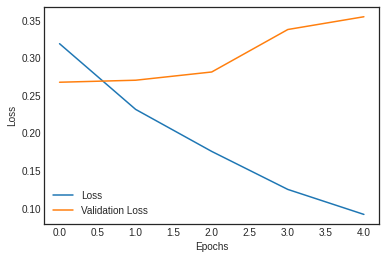

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss','Validation Loss'])
plt.show()

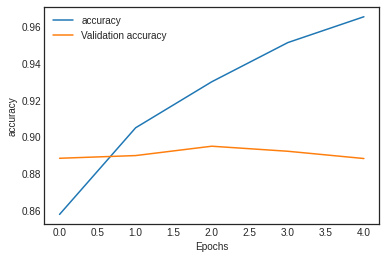

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],'')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy','Validation accuracy'])
plt.show()

## 모델 평가

In [71]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document','label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

TypeError: ignored

In [72]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

6/6 [==============================] - 14s 2s/step - loss: 0.2886 - accuracy: 0.8879


[0.2885681986808777, 0.8879220485687256]